In [1]:
import taichi as ti
import numpy as np
from typing import Tuple
import napari
import matplotlib.pyplot as plt

[Taichi] version 1.7.4, llvm 15.0.1, commit b4b956fd, win, python 3.11.5


In [2]:
ti.init(ti.gpu)

[Taichi] Starting on arch=cuda


In [3]:
# 2. Define volume parameters
N = 128  # Size of the 3D volume (N x N x N)
volume_shape = (N, N, N)

# 3. Define the three spheres (Center X, Center Y, Center Z, Radius, Value/Intensity)
# Values are normalized to the range [0.0, 1.0] for visualization.
# Spheres are checked in order (3, 2, 1), so Sphere 3 has drawing priority if there is overlap.
SPHERES = [
    # Sphere 1 (Low Intensity)
    {'center': ti.Vector([40.0, 75.0, 40.0]), 'radius': 30.0, 'radius2': 20.0, 'value': 0.5},
    # Sphere 2 (Medium Intensity)
    {'center': ti.Vector([88.0, 88.0, 40.0]), 'radius': 25.0, 'radius2': 10.0, 'value': 0.7},
    # Sphere 3 (High Intensity)
    {'center': ti.Vector([40.0, 88.0, 88.0]), 'radius': 20.0, 'radius2': 18.0, 'value': 1.0},
]

# 4. Define the Taichi field
# 'f32' is used for floating-point values
volume = ti.field(dtype=ti.f32, shape=volume_shape)
interactions = ti.field(dtype=ti.f32, shape=volume_shape)
out = ti.field(dtype=ti.f32, shape=volume_shape)

@ti.kernel
def generate_spheres():
    """
    Fills the volume field with three distinct spheres.
    """

    s3 = SPHERES[2]
    s2 = SPHERES[1]
    s1 = SPHERES[0]

    # Iterate over every element in the 3D field (using the robust ti.ndrange syntax)
    for i, j, k in ti.ndrange(N, N, N):
        # Current voxel coordinates as a Taichi Vector
        current_coord = ti.Vector([float(i), float(j), float(k)])
        
        # Start with a background value of 0.0
        voxel_value = 0.0

        # Sphere 3 (Highest priority for potential overlap)

        dist_sq_1 = (current_coord - s1['center']).norm()**2
        if dist_sq_1 < s1['radius'] ** 2  and dist_sq_1 > s1['radius2'] ** 2:
            voxel_value = s1['value']

        dist_sq_2 = (current_coord - s2['center']).norm()**2
        if dist_sq_2 < s2['radius'] ** 2  and dist_sq_2 > s2['radius2'] ** 2:
            voxel_value = s2['value']

        dist_sq_3 = (current_coord - s3['center']).norm()**2
        if dist_sq_3 < s3['radius'] ** 2 and dist_sq_3 > s3['radius2'] ** 2:
            voxel_value = s3['value']
        
        

        

        # Store the value in the Taichi field
        volume[i, j, k] = voxel_value

In [4]:
@ti.data_oriented
class EllipticalBeamGenerator:
    """
    Generate photons from an elliptical source with Gaussian distribution.
    The photons are all parallel to the beam axis (from source center to target point).
    Uses Taichi for efficient parallel computation.
    """
    
    def __init__(self, 
                 central_point: Tuple[float, float, float],
                 distance: float,
                 theta: float,  # polar angle in radians
                 phi: float,    # azimuthal angle in radians
                 mask_diameter: float,  # diameter to which the beam is masked
                 sigma_a: float,    # Gaussian beam width parameter
                 sigma_b: float,    # Gaussian beam width parameter
                 divergence_a: float,
                 divergence_b: float,
                 divergence_sigma_a: float,
                 divergence_sigma_b: float):
        """
        Initialize the elliptical beam generator.
        
        Parameters:
        -----------
        central_point : tuple
            Target point (x0, y0, z0)
        distance : float
            Distance from central point to source center
        theta : float
            Polar angle (from z-axis) in radians
        phi : float
            Azimuthal angle (from x-axis in xy-plane) in radians
        mask_diameter: float
            Limit photon generation to within this diameter (typically set by illuminated volume)
        sigma_a: float
            Semi-major axis beam size
        sigma_b: float
            Semi-minor axis beam size
        divergence_a: float
            Semi-major axis beam divergence (radians) at 1 sigma distance from axis
        divergence_b: float
            Semi-minor axis beam divergence (radians) at 1 sigma distance from axis
        divergence_sigma_a: float
            Semi-major axis beam divergence spread (radians)
        divergence_sigma_b: float
            Semi-minor axis beam divergence spread (radians)
        """
        self.central_point = np.array(central_point)
        self.distance = distance
        self.theta = theta
        self.phi = phi
        self.mask_diameter = mask_diameter
        self.sigma_a = sigma_a
        self.sigma_b = sigma_b
        self.divergence_a = divergence_a
        self.divergence_b = -divergence_b  # it is unclear why this needs to be reversed
        self.divergence_sigma_a = divergence_sigma_a
        self.divergence_sigma_b = divergence_sigma_b
        
        # Calculate source center position using spherical coordinates
        self.source_center = self._calculate_source_center()
        
        # Calculate beam direction (from source to central point)
        self.beam_direction = self._calculate_beam_direction()

        # Calculate focal distances if convergent
        self._calculate_focal_parameters()
        
        # Create local coordinate system for the ellipse
        self.local_x, self.local_y, self.local_z = self._create_local_coords()
        
        # Create Taichi fields to store parameters (scalar fields)
        self.ti_source_center = ti.Vector.field(3, dtype=ti.f32, shape=())
        self.ti_local_x = ti.Vector.field(3, dtype=ti.f32, shape=())
        self.ti_local_y = ti.Vector.field(3, dtype=ti.f32, shape=())
        self.ti_local_z = ti.Vector.field(3, dtype=ti.f32, shape=())
        
        # Copy to Taichi fields
        self.ti_source_center[None] = ti.Vector(self.source_center.tolist())
        self.ti_local_x[None] = ti.Vector(self.local_x.tolist())
        self.ti_local_y[None] = ti.Vector(self.local_y.tolist())
        self.ti_local_z[None] = ti.Vector(self.local_z.tolist())
    
    def _calculate_source_center(self) -> np.ndarray:
        """Calculate the position of the source center in global coordinates."""
        # Convert spherical to Cartesian (source is at distance d from central point)
        dx = self.distance * np.sin(self.theta) * np.cos(self.phi)
        dy = self.distance * np.sin(self.theta) * np.sin(self.phi)
        dz = self.distance * np.cos(self.theta)
        
        # Source is positioned away from central point
        source_center = self.central_point + np.array([dx, dy, dz])
        return source_center
    
    def _calculate_beam_direction(self) -> np.ndarray:
        """Calculate normalized beam direction (from source to central point)."""
        direction = self.central_point - self.source_center
        return direction / np.linalg.norm(direction)
    
    def _calculate_focal_parameters(self):
        """
        Calculate focal points and distances for convergent beams.
        
        For convergent beams, the focal distance is where rays from 1 sigma 
        would converge if extrapolated.
        """
        # For major axis
        if abs(self.divergence_a) > 0 and self.sigma_a > 0:
            # At 1 sigma, the ray has angle divergence_a
            # tan(angle) = sigma / focal_distance
            self.focal_distance_a = - self.sigma_a / np.tan(self.divergence_a)
            self.focal_point_a = self.source_center + self.focal_distance_a * self.beam_direction
        else:
            self.focal_distance_a = np.inf
            self.focal_point_a = None
        
        # For minor axis
        if abs(self.divergence_b) > 0 and self.sigma_b > 0:  # Convergent
            self.focal_distance_b = - self.sigma_b / np.tan(self.divergence_b)
            self.focal_point_b = self.source_center + self.focal_distance_b * self.beam_direction
        else:
            self.focal_distance_b = np.inf
            self.focal_point_b = None

    def _create_local_coords(self) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
        """
        Create a local coordinate system for the ellipse plane.
        local_z points along the beam direction (inward)
        local_x and local_y span the ellipse plane
        """
        local_z = self.beam_direction
        
        # Choose an arbitrary vector not parallel to local_z
        if abs(local_z[2]) < 0.9:
            arbitrary = np.array([0, 0, 1])
        else:
            arbitrary = np.array([1, 0, 0])
        
        # Create orthonormal basis using Gram-Schmidt
        local_x = arbitrary - np.dot(arbitrary, local_z) * local_z
        local_x = local_x / np.linalg.norm(local_x)
        
        local_y = np.cross(local_z, local_x)
        
        return local_x, local_y, local_z

    @ti.func
    def _ti_calculate_photon_direction(self, u_coord: ti.f32, v_coord: ti.f32) -> ti.math.vec3:
        """
        Calculate the direction vector for a photon based on its position.
        
        The divergence angle is proportional to the distance from the center,
        scaled so that photons at 1 sigma have the specified divergence angle.
        
        Parameters:
        -----------
        u_coord : float
            Local coordinate along major axis
        v_coord : float
            Local coordinate along minor axis
        
        Returns:
        --------
        direction : vec3
            Unit direction vector for the photon
        """
        # Calculate position-dependent divergence angles
        position_divergence_a = 0.0
        position_divergence_b = 0.0
        
        if self.sigma_a > 0:
            position_divergence_a = (u_coord / self.sigma_a) * self.divergence_a
        
        if self.sigma_b > 0:
            position_divergence_b = (v_coord / self.sigma_b) * self.divergence_b
        
        # Add random divergence component
        random_divergence_a = ti.randn() * self.divergence_sigma_a
        random_divergence_b = ti.randn() * self.divergence_sigma_b
        
        total_angle_a = position_divergence_a + random_divergence_a
        total_angle_b = position_divergence_b + random_divergence_b
        
        # Start with beam direction
        local_z = self.ti_local_z[None]
        local_x = self.ti_local_x[None]
        local_y = self.ti_local_y[None]
        
        direction = local_z
        
        # Rotation around local_y axis (affects x-z plane)
        if total_angle_a != 0.0:
            cos_a = ti.cos(total_angle_a)
            sin_a = ti.sin(total_angle_a)
            # Rodrigues' rotation formula
            direction = cos_a * direction + sin_a * ti.math.cross(local_y, direction)
        
        # Rotation around local_x axis (affects y-z plane)
        if total_angle_b != 0.0:
            cos_b = ti.cos(total_angle_b)
            sin_b = ti.sin(total_angle_b)
            direction = cos_b * direction + sin_b * ti.math.cross(local_x, direction)
        
        direction = ti.math.normalize(direction)
        
        return direction

    @ti.kernel
    def _generate_and_filter_samples(self, 
                                     positions: ti.types.ndarray(),
                                     directions: ti.types.ndarray(),
                                     rotation_angle: ti.f32) -> ti.i32:
        """
        Generate photon positions and directions using Taichi kernel.
        Each thread generates one valid photon by retrying until successful.
        Returns the number of samples generated (should equal n_photons).
        """
        n_photons = positions.shape[0]
        source_center = self.ti_source_center[None]
        local_x = self.ti_local_x[None]
        local_y = self.ti_local_y[None]
        
        cos_r = ti.cos(rotation_angle)
        sin_r = ti.sin(rotation_angle)
        mask_radius_sq = (self.mask_diameter / 2.0) ** 2
        
        # Each thread generates one valid sample
        for i in range(n_photons):
            # Keep trying until we get a valid sample
            valid = False
            u = 0.0
            v = 0.0
            
            # Try up to 1000 times to get a valid sample
            for attempt in range(1000):
                if not valid:
                    # Generate 2D Gaussian samples
                    u = ti.randn() * self.sigma_a
                    v = ti.randn() * self.sigma_b
                    
                    # Apply rotation in the ellipse plane
                    if rotation_angle != 0.0:
                        u_rot = cos_r * u - sin_r * v
                        v_rot = sin_r * u + cos_r * v
                        u = u_rot
                        v = v_rot
                    
                    # Check if within mask
                    if u * u + v * v < mask_radius_sq:
                        valid = True
            
            # Position in global coordinates
            pos = source_center + u * local_x + v * local_y
            
            # Direction with position-dependent divergence
            direction = self._ti_calculate_photon_direction(u, v)
            
            # Store result
            positions[i, 0] = pos[0]
            positions[i, 1] = pos[1]
            positions[i, 2] = pos[2]
            
            directions[i, 0] = direction[0]
            directions[i, 1] = direction[1]
            directions[i, 2] = direction[2]
        
        return n_photons

    def generate_photons(self, n_photons: int, 
                        rotation_angle: float = 0.0,
                        truncate_at: float = 3.0) -> Tuple[ti.types.ndarray(), ti.types.ndarray()]:
        """
        Generate n photons with Gaussian distribution in the ellipse.
        Returns Taichi arrays for efficient GPU/parallel computation.
        
        Parameters:
        -----------
        n_photons : int
            Number of photons to generate
        rotation_angle : float
            Rotation angle of the ellipse in its plane (radians)
        truncate_at : float
            Truncate Gaussian at this many sigmas (to keep points within ellipse)
        
        Returns:
        --------
        positions : Taichi ndarray of shape (n_photons, 3)
            3D positions of photons
        directions : Taichi ndarray of shape (n_photons, 3)
            Direction vectors (all parallel to beam axis)
        """
        # Allocate Taichi arrays
        positions = ti.ndarray(dtype=ti.f32, shape=(n_photons, 3))
        directions = ti.ndarray(dtype=ti.f32, shape=(n_photons, 3))
        
        # Generate samples
        count = self._generate_and_filter_samples(
            positions, 
            directions, 
            float(rotation_angle)
        )
        
        return positions, directions

In [5]:
# generate our 3D shapes and projections

generate_spheres()

# --- Visualization with napari ---

# Convert the Taichi field data to a NumPy array for napari
volume_np = volume.to_numpy()

# generate some projections
proj0 = volume_np.sum(axis=0)
proj0_3d = proj0[np.newaxis, :, :]  # Shape: (1, Y, X)

proj1 = volume_np.sum(axis=1)
proj1_3d = proj1[:, np.newaxis, :]  # Shape: (Z, 1, X)

proj2 = volume_np.sum(axis=2)
proj2_3d = proj2[:, :, np.newaxis]  # Shape: (Z, Y, 1)

In [6]:
# generate MC light packets
# Set up beam parameters
central_point = (64, 84, 64)  # Target at origin
distance = np.sqrt(2)*64+1  # Source 10 units away
theta = 0*np.pi/2  # 45 degrees from z-axis
phi = np.pi/2    # 30 degrees in xy-plane
mask_diameter = 1.5*np.sqrt(128**2)
sigma_a = 256
sigma_b = 256
divergence_a = -0.02
divergence_b = -0.02         # why is this sign reversed?
divergence_sigma_a = 0.005
divergence_sigma_b = 0.005

# Create beam generator
beam = EllipticalBeamGenerator(
    central_point=central_point,
    distance=distance,
    theta=theta,
    phi=phi,
    mask_diameter=mask_diameter,
    sigma_a=sigma_a,
    sigma_b=sigma_b,
    divergence_a=divergence_a,
    divergence_b=divergence_b,
    divergence_sigma_a=divergence_sigma_a,
    divergence_sigma_b=divergence_sigma_b
)

@ti.kernel
def init_states(n_photons: int, intensities: ti.types.ndarray(), entered_ti: ti.types.ndarray(), 
                exited_ti:ti.types.ndarray(), bounces: ti.types.ndarray(), 
                last_scatter_pos: ti.types.ndarray()):
    for i in range(n_photons):
        intensities[i] = 0.01
        entered_ti[i] = 1
        exited_ti[i] = 1
        bounces[i] = 0
        # Initialize last scatter position to starting position
        for j in ti.static(range(3)):
            last_scatter_pos[i, j] = 0.0

# Generate photons for simulation
n_photons = 100000000
positions_ti, directions_ti = beam.generate_photons(n_photons)
intensities_ti = ti.ndarray(dtype=ti.f32, shape=(n_photons))
entered_ti = ti.ndarray(dtype=ti.i32, shape=(n_photons))
exited_ti = ti.ndarray(dtype=ti.i32, shape=(n_photons))
bounces_ti = ti.ndarray(dtype=ti.i32, shape=(n_photons))
last_scatter_pos_ti = ti.ndarray(dtype=ti.f32, shape=(n_photons, 3))  # Track last scatter position
init_states(n_photons, intensities_ti, entered_ti, exited_ti, bounces_ti, last_scatter_pos_ti)

# Trajectory tracking for first N photons
n_tracked = 100
max_steps = 10*round(distance)
trajectory_positions = ti.ndarray(dtype=ti.f32, shape=(n_tracked, max_steps, 3))
trajectory_valid = ti.ndarray(dtype=ti.i32, shape=(n_tracked, max_steps))  # 1 if position is valid

@ti.kernel
def init_trajectories(trajectory_positions: ti.types.ndarray(), trajectory_valid: ti.types.ndarray()):
    for i, j in ti.ndrange(n_tracked, max_steps):
        trajectory_valid[i, j] = 0
        for k in ti.static(range(3)):
            trajectory_positions[i, j, k] = 0.0
            
init_trajectories(trajectory_positions, trajectory_valid)


In [7]:
# Initialize the napari viewer
viewer = napari.Viewer(title="3D Test Volume", ndisplay=3)

In [8]:
viewer.add_image(
    volume_np, 
    name='3D Index', 
    colormap='turbo', 
    contrast_limits=[0, 1],
    rendering='average',
    blending='additive'
)

# add the same volume and render as plane
# plane should be in 'additive' blending mode or depth looks all wrong

sum0_layer = viewer.add_image(
    proj0_3d,
    rendering='average',
    name='sum0',
    depiction='plane',
    blending='additive',
    opacity=0.25,
    plane={'position': (0, N/2, N/2),'normal': (1, 0, 0)}
)

sum1_layer = viewer.add_image(
    proj1_3d,
    rendering='average',
    name='sum1',
    depiction='plane',
    blending='additive',
    opacity=0.25,
    plane={'position': (N/2, 0, N/2),'normal': (0, 1, 0)}
)

sum2_layer = viewer.add_image(
    proj2_3d,
    rendering='average',
    name='sum2',
    depiction='plane',
    blending='additive',
    opacity=0.25,
    plane={'position': (N/2, N/2, 0),'normal': (0, 0, 1)}
)

In [9]:
positions = positions_ti.to_numpy()
directions = directions_ti.to_numpy()
end_positions = positions + 2 * distance * directions
lines = np.stack((positions, end_positions), axis=1)
#viewer.add_points(positions, size=0.25, border_width=0, face_color='white', opacity=0.3)
#viewer.add_points(end_positions, size=0.25, border_width=0, face_color='white', opacity=0.25)
#viewer.add_shapes(lines, shape_type='line', edge_width=0.2, edge_color='yellow', opacity=0.03)
axes = np.array((
    [[0, 0, 0], [128,0,0]],
    [[0, 0, 0], [0, 128, 0]],
    [[0, 0, 0], [0, 0, 128]])
)
viewer.add_shapes(axes[0], shape_type='line', edge_width=0.2, edge_color='red', opacity=0.75, name='axis-0')
viewer.add_shapes(axes[1], shape_type='line', edge_width=0.2, edge_color='green', opacity=0.75, name='axis-1')
viewer.add_shapes(axes[2], shape_type='line', edge_width=0.2, edge_color='blue', opacity=0.75, name='axis-2')


<Shapes layer 'axis-2' at 0x27be1498bd0>

In [10]:
# calculate local gradients
gradient_mag = ti.field(dtype=ti.f32, shape=volume.shape)
gradient_dir = ti.Vector.field(3, dtype=ti.f32, shape=volume.shape)

@ti.kernel
def compute_gradient():
    h = ti.static(1)
    # Precompute normalization factor sigma = sum(ox^2) over ox * (2h+1)^2
    sigma = 0.0
    for ox in ti.static(range(-h, h + 1)):
        sigma += ox * ox
    sigma *= (2 * h + 1) ** 2
    #if sigma == 0.0:  # Avoid division by zero (though N>=3)
    #    return

    for i, j, k in volume:
        # Skip boundaries (you can add padding or mirroring if needed)
        if i < h or i >= nx - h or j < h or j >= ny - h or k < h or k >= nz - h:
            gradient_mag[i, j, k] = 0.0
            gradient_dir[i, j, k] = ti.Vector([0.0, 0.0, 0.0])
            continue

        gx = 0.0
        gy = 0.0
        gz = 0.0
        # Loop over neighborhood
        for ox in ti.static(range(-h, h + 1)):
            for oy in ti.static(range(-h, h + 1)):
                for oz in ti.static(range(-h, h + 1)):
                    f = volume[i + ox, j + oy, k + oz]
                    gx += ox * f
                    gy += oy * f
                    gz += oz * f

        gx /= sigma
        gy /= sigma
        gz /= sigma

        mag = ti.sqrt(gx * gx + gy * gy + gz * gz)
        gradient_mag[i, j, k] = mag

        if mag > 1e-6:
            gradient_dir[i, j, k] = ti.Vector([gx / mag, gy / mag, gz / mag])
        else:
            gradient_dir[i, j, k] = ti.Vector([0.0, 0.0, 0.0])
            gradient_mag[i, j, k] = 0.0

# Usage example
nx, ny, nz = 128, 128, 128
compute_gradient()  # Change to 5, 7, etc.
if False:
    mag_np = gradient_mag.to_numpy()
    dir_np = gradient_dir.to_numpy()
    viewer.add_image(
    mag_np, 
    name='3D Index', 
    colormap='red', 
    contrast_limits=[0, 1],
    rendering='average',
    blending='additive'
    )
    viewer.add_vectors(
        dir_np, 
        name='Gradient Dir', 
        edge_color='red'
    )

In [11]:
@ti.kernel
def propagate_photons(positions: ti.types.ndarray(), directions: ti.types.ndarray(), step: ti.f32, 
                       trajectory_positions: ti.types.ndarray(), trajectory_valid: ti.types.ndarray(), step_idx: ti.i32):
    for i in ti.ndrange(positions.shape[0]):
        # Record position for tracked photons BEFORE propagation
        if i < n_tracked and step_idx < max_steps:
            for k in ti.static(range(3)):
                trajectory_positions[i, step_idx, k] = positions[i, k]
            trajectory_valid[i, step_idx] = 1
        
        # Propagate all photons
        for j in ti.static(range(3)):       # unroll this loop
            positions[i,j] += directions[i,j] * step

In [12]:
@ti.kernel
def interact_photons(positions: ti.types.ndarray(), intensities: ti.types.ndarray(), entered: ti.types.ndarray(), 
                     exited: ti.types.ndarray(), directions: ti.types.ndarray(), bounces: ti.types.ndarray(),
                     last_scatter_pos: ti.types.ndarray()):
    for i in ti.ndrange(positions.shape[0]):
        if intensities[i] > 0:
            x = ti.cast(positions[i, 0], ti.i32)
            y = ti.cast(positions[i, 1], ti.i32)
            z = ti.cast(positions[i, 2], ti.i32)
            if 0 <= x < N and 0 <= y < N and 0 <= z < N:
                if entered[i] == 0:
                    entered[i] = 1
                rand = ti.random()
                # absorption
                if rand < 0.00 * volume[x, y, z]:
                    interactions[x, y, z] += intensities[i]
                    intensities[i] = 0
                # isotropic scattering
                elif rand < 0.1 * volume[x, y, z]:
                    phi = 2*np.pi*ti.random()
                    u = 2*ti.random() - 1
                    directions[i, 0] = ti.sqrt(1 - u*u) * ti.cos(phi)
                    directions[i, 1] = ti.sqrt(1 - u*u) * ti.sin(phi)
                    directions[i, 2] = u
                    bounces[i] += 1
                    # Record last scatter position
                    last_scatter_pos[i, 0] = positions[i, 0]
                    last_scatter_pos[i, 1] = positions[i, 1]
                    last_scatter_pos[i, 2] = positions[i, 2]
                """
                interact = intensities[i] * volume[x, y, z] * 0.2
                interactions[x, y, z] += interact
                intensities[i] -= interact
                """
            elif entered[i] == 1 and intensities[i] > 0:
                # Check if photon exited from any edge
                if x < 0 or x >= N or y < 0 or y >= N or z < 0 or z >= N:
                    exited[i] = 1
                    entered[i] = 0
                    if z < N:
                        x_clamped = ti.max(0, ti.min(N-1, x))
                        y_clamped = ti.max(0, ti.min(N-1, y))
                        z_clamped = ti.max(0, ti.min(N-1, z))
                        out[x_clamped, y_clamped, z_clamped] += intensities[i]

# Run simulation with trajectory tracking
for step_idx in range(10*round(distance)):
    propagate_photons(positions_ti, directions_ti, 0.5, trajectory_positions, trajectory_valid, step_idx)
    interact_photons(positions_ti, intensities_ti, entered_ti, exited_ti, directions_ti, bounces_ti, last_scatter_pos_ti)

In [13]:
interactions_np = interactions.to_numpy()
viewer.add_image(
    interactions_np, 
    name='3D Interactions', 
    colormap='turbo', 
    contrast_limits=[0, 1],
    rendering='average',
    blending='additive'
)

output_np = out.to_numpy()
viewer.add_image(
    output_np, 
    name = 'Exiting Light',
    colormap='turbo',
    contrast_limits=[0, 1],
    rendering='average',
    blending='additive'
)

<Image layer 'Exiting Light' at 0x27bd94afe50>

(array([9.7711399e+07, 1.7339870e+06, 4.2943500e+05, 9.0309000e+04,
        2.5222000e+04, 7.6000000e+03, 1.6250000e+03, 3.7200000e+02,
        4.8000000e+01, 3.0000000e+00]),
 array([ 0. ,  7.4, 14.8, 22.2, 29.6, 37. , 44.4, 51.8, 59.2, 66.6, 74. ]),
 <BarContainer object of 10 artists>)

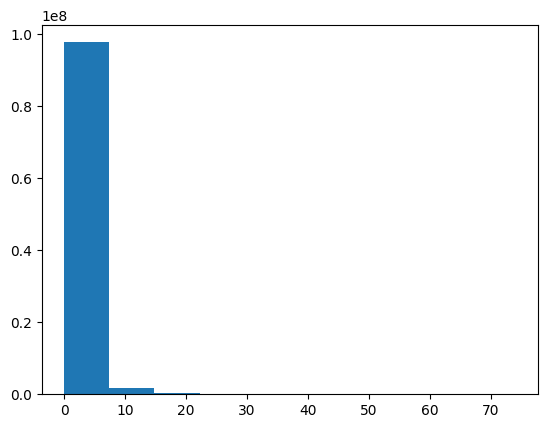

In [14]:
plt.hist(bounces_ti.to_numpy())

In [15]:
# Enhanced microscope with depth-dependent defocus blur
from scipy import ndimage

class TaichiMicroscopeWithDefocus:
    """
    Virtual microscope with depth-dependent defocus blur.
    Each photon is rendered as a Gaussian whose width depends on the distance
    from its last scatter position to the focal plane.
    """
    
    def __init__(self, 
                 observation_face: str = '+z',
                 volume_size: int = 128,
                 voxel_size: float = 1.0,  # microns
                 NA: float = 0.65,
                 magnification: float = 20.0,
                 n_medium: float = 1.33,
                 sensor_size: tuple = (512, 512),
                 pixel_size: float = 6.5,  # microns
                 wavelength: float = 550.0,  # nm
                 focal_depth: float = 64.0):  # voxel coordinates
        """
        Initialize microscope with defocus capability.
        
        Args:
            focal_depth: Depth of focal plane in voxel coordinates (e.g., 64 for center)
        """
        self.observation_face = observation_face
        self.volume_size = volume_size
        self.voxel_size = voxel_size
        self.NA = NA
        self.magnification = magnification
        self.n_medium = n_medium
        self.sensor_size = sensor_size
        self.pixel_size = pixel_size
        self.wavelength = wavelength
        self.focal_depth = focal_depth
        
        # Calculate acceptance angle
        self.acceptance_angle = np.arcsin(NA / n_medium)
        
        # Map face to normal direction and coordinate system
        self.face_config = self._setup_face_geometry()
        
        # Field of view in object space (microns)
        self.fov_x = sensor_size[0] * pixel_size / magnification
        self.fov_y = sensor_size[1] * pixel_size / magnification
        
        # Physical volume dimensions
        self.volume_extent = volume_size * voxel_size  # microns
        
        # PSF parameters - minimum blur (in-focus)
        self.airy_radius = 0.61 * (wavelength / 1000) / NA  # microns
        self.min_sigma_pixels = (self.airy_radius * magnification / pixel_size) / 2.355
        
        # Depth of field (microns)
        self.dof = (wavelength / 1000) / (2 * NA**2)  # microns
        self.dof_voxels = self.dof / voxel_size  # convert to voxel units
        
        print(f"Taichi Microscope with Defocus initialized:")
        print(f"  Observation face: {observation_face}")
        print(f"  Focal depth: {focal_depth} voxels ({focal_depth * voxel_size:.1f} μm)")
        print(f"  Depth of field: {self.dof:.2f} μm ({self.dof_voxels:.2f} voxels)")
        print(f"  NA: {NA}, Acceptance angle: {np.degrees(self.acceptance_angle):.1f}°")
        print(f"  Min sigma (in-focus): {self.min_sigma_pixels:.2f} pixels")
    
    def _setup_face_geometry(self):
        """Set up coordinate system for each face."""
        configs = {
            '+z': {
                'normal': np.array([0, 0, 1]),
                'face_coord': 2,  # z-axis
                'face_value': self.volume_size,
                'tangent_coords': [0, 1],  # x, y
                'depth_coord': 2,  # z is depth
            },
            '-z': {
                'normal': np.array([0, 0, -1]),
                'face_coord': 2,
                'face_value': 0,
                'tangent_coords': [0, 1],
                'depth_coord': 2,
            },
            '+x': {
                'normal': np.array([1, 0, 0]),
                'face_coord': 0,
                'face_value': self.volume_size,
                'tangent_coords': [1, 2],  # y, z
                'depth_coord': 0,  # x is depth
            },
            '-x': {
                'normal': np.array([-1, 0, 0]),
                'face_coord': 0,
                'face_value': 0,
                'tangent_coords': [1, 2],
                'depth_coord': 0,
            },
            '+y': {
                'normal': np.array([0, 1, 0]),
                'face_coord': 1,
                'face_value': self.volume_size,
                'tangent_coords': [0, 2],  # x, z
                'depth_coord': 1,  # y is depth
            },
            '-y': {
                'normal': np.array([0, -1, 0]),
                'face_coord': 1,
                'face_value': 0,
                'tangent_coords': [0, 2],
                'depth_coord': 1,
            },
        }
        return configs[self.observation_face]
    
    def calculate_defocus_sigma(self, scatter_depths):
        """
        Calculate defocus blur (sigma) based on distance from focal plane.
        
        Args:
            scatter_depths: Depth coordinate of last scatter position (voxels)
            
        Returns:
            sigma in pixels for each photon
        """
        # Distance from focal plane (in voxels)
        defocus_distance = np.abs(scatter_depths - self.focal_depth)
        
        # Geometric blur increases linearly with defocus distance
        # Circle of confusion radius = defocus * tan(acceptance_angle)
        coc_radius_voxels = defocus_distance * np.tan(self.acceptance_angle)
        coc_radius_microns = coc_radius_voxels * self.voxel_size
        coc_radius_pixels = coc_radius_microns * self.magnification / self.pixel_size
        
        # Total blur is combination of diffraction (min_sigma) and defocus
        # Use quadrature sum (sqrt of sum of squares)
        total_sigma = np.sqrt(self.min_sigma_pixels**2 + (coc_radius_pixels / 2.355)**2)
        
        return total_sigma
    
    def filter_photons_by_face(self, positions_np, intensities_np, entered_np, exited_np):
        """Filter photons that exited through the observation face."""
        config = self.face_config
        face_coord = config['face_coord']
        face_value = config['face_value']
        
        has_exited = exited_np == 1
        tolerance = 1.5
        
        if face_value == 0:
            at_face = positions_np[:, face_coord] < tolerance
        else:
            at_face = positions_np[:, face_coord] > (face_value - tolerance)
        
        return has_exited & at_face
    
    def filter_by_na(self, directions_np, mask):
        """Filter photons by numerical aperture."""
        valid_dirs = directions_np[mask]
        if len(valid_dirs) == 0:
            return mask
        
        normal = self.face_config['normal']
        cos_angles = np.sum(valid_dirs * normal, axis=1)
        angles = np.arccos(np.clip(cos_angles, -1, 1))
        within_na = angles <= self.acceptance_angle
        
        result_mask = mask.copy()
        result_mask[mask] = within_na
        return result_mask
    
    def form_image_with_defocus(self, positions_np, directions_np, intensities_np, 
                                 entered_np, exited_np, last_scatter_pos_np):
        """
        Form microscope image with depth-dependent defocus blur.
        Each photon is rendered as a Gaussian splat.
        
        Args:
            last_scatter_pos_np: Position where each photon last scattered (n_photons, 3)
        """
        # Step 1: Filter by face
        face_mask = self.filter_photons_by_face(
            positions_np, intensities_np, entered_np, exited_np
        )
        
        # Step 2: Filter by NA
        na_mask = self.filter_by_na(directions_np, face_mask)
        
        n_accepted = na_mask.sum()
        if n_accepted == 0:
            print(f"Warning: No photons accepted for face {self.observation_face}")
            return np.zeros(self.sensor_size)
        
        # Step 3: Get data for accepted photons
        config = self.face_config
        tangent_coords = config['tangent_coords']
        depth_coord = config['depth_coord']
        
        # Exit positions in microns
        exit_pos = positions_np[na_mask] * self.voxel_size
        scatter_pos = last_scatter_pos_np[na_mask]
        weights = intensities_np[na_mask]
        
        # Project to sensor coordinates
        x_obj = exit_pos[:, tangent_coords[0]]
        y_obj = exit_pos[:, tangent_coords[1]]
        
        sensor_x = x_obj * self.magnification / self.pixel_size + self.sensor_size[0] / 2
        sensor_y = y_obj * self.magnification / self.pixel_size + self.sensor_size[1] / 2
        
        # Get scatter depths
        scatter_depths = scatter_pos[:, depth_coord]
        
        # Calculate per-photon sigma
        sigmas = self.calculate_defocus_sigma(scatter_depths)
        
        # Render each photon as a Gaussian
        image = self._render_gaussian_photons(sensor_x, sensor_y, weights, sigmas)
        
        print(f"Face {self.observation_face}: {face_mask.sum()} photons at face, "
              f"{n_accepted} within NA")
        print(f"  Sigma range: [{sigmas.min():.2f}, {sigmas.max():.2f}] pixels")
        print(f"  Peak intensity: {image.max():.2e}")
        
        return image.T
    
    def _render_gaussian_photons(self, sensor_x, sensor_y, weights, sigmas):
        """
        Render photons as Gaussian splats.
        
        This is the key function that implements depth-dependent blur!
        """
        image = np.zeros(self.sensor_size, dtype=np.float32)
        
        # For efficiency, group photons by similar sigma
        sigma_bins = np.linspace(sigmas.min(), sigmas.max(), 50)
        sigma_indices = np.digitize(sigmas, sigma_bins)
        
        for bin_idx in range(len(sigma_bins) + 1):
            mask = sigma_indices == bin_idx
            if not mask.any():
                continue
            
            bin_sigma = sigmas[mask].mean()
            bin_x = sensor_x[mask]
            bin_y = sensor_y[mask]
            bin_w = weights[mask]
            
            # Create Gaussian kernel for this bin
            kernel_radius = int(np.ceil(3 * bin_sigma))
            if kernel_radius < 1:
                kernel_radius = 1
            
            kernel_size = 2 * kernel_radius + 1
            y_k, x_k = np.ogrid[-kernel_radius:kernel_radius+1, -kernel_radius:kernel_radius+1]
            kernel = np.exp(-(x_k**2 + y_k**2) / (2 * bin_sigma**2))
            kernel /= kernel.sum()
            kernel /= bin_sigma
            
            # Splat photons onto image
            for i in range(len(bin_x)):
                ix = int(np.round(bin_x[i]))
                iy = int(np.round(bin_y[i]))
                
                # Skip if outside sensor
                if ix < kernel_radius or ix >= self.sensor_size[0] - kernel_radius:
                    continue
                if iy < kernel_radius or iy >= self.sensor_size[1] - kernel_radius:
                    continue
                
                # Add Gaussian splat
                x_start = ix - kernel_radius
                x_end = ix + kernel_radius + 1
                y_start = iy - kernel_radius
                y_end = iy + kernel_radius + 1
                
                image[x_start:x_end, y_start:y_end] += bin_w[i] * kernel
        
        return image

In [16]:
# Create microscope with depth-dependent defocus
positions_np = positions_ti.to_numpy()
directions_np = directions_ti.to_numpy()
intensities_np = intensities_ti.to_numpy()
entered_np = entered_ti.to_numpy()
exited_np = exited_ti.to_numpy()
last_scatter_pos_np = last_scatter_pos_ti.to_numpy()

# Create defocus microscope
microscope_defocus = TaichiMicroscopeWithDefocus(
    observation_face='+x',
    volume_size=N,
    voxel_size=1.0,
    NA=0.65,
    magnification=20,
    sensor_size=(N, N),
    focal_depth=7.0  # Focus at center of volume
)

# Form image with defocus
image_defocus = microscope_defocus.form_image_with_defocus(
    positions_np, directions_np, intensities_np,
    entered_np, exited_np, last_scatter_pos_np
)

# Add to viewer
if image_defocus.max() > 0:
    viewer.add_image(
        image_defocus,
        name='Microscope with Defocus (+x)',
        colormap='gray',
        contrast_limits=[0, image_defocus.max()],
        rendering='translucent',
        opacity=1.0
    )
    print(f"\nAdded defocus microscope image to viewer")
    print(f"  Image shape: {image_defocus.shape}")
    print(f"  Intensity range: [{image_defocus.min():.2e}, {image_defocus.max():.2e}]")
else:
    print("No signal in defocus microscope image")

Taichi Microscope with Defocus initialized:
  Observation face: +x
  Focal depth: 7.0 voxels (7.0 μm)
  Depth of field: 0.65 μm (0.65 voxels)
  NA: 0.65, Acceptance angle: 29.3°
  Min sigma (in-focus): 0.67 pixels
Face +x: 16986374 photons at face, 949126 within NA
  Sigma range: [3.01, 77.58] pixels
  Peak intensity: 1.04e-04

Added defocus microscope image to viewer
  Image shape: (128, 128)
  Intensity range: [0.00e+00, 1.04e-04]


In [17]:
# Convert trajectories to numpy and create line segments for napari
trajectory_pos_np = trajectory_positions.to_numpy()
trajectory_valid_np = trajectory_valid.to_numpy()

# Build line segments for each tracked photon
all_lines = []
for photon_idx in range(n_tracked):
    # Find all valid positions for this photon
    valid_steps = np.where(trajectory_valid_np[photon_idx] == 1)[0]
    
    if len(valid_steps) > 1:
        # Create line segments connecting consecutive positions
        photon_path = trajectory_pos_np[photon_idx, valid_steps, :]
        
        # Create lines from point to point, only if both endpoints are within bounds
        for i in range(len(photon_path) - 1):
            p1 = photon_path[i]
            p2 = photon_path[i+1]
            
            # Check if both points are within [0, N] bounds for all dimensions
            p1_in_bounds = np.all((p1 >= 0) & (p1 <= N))
            p2_in_bounds = np.all((p2 >= 0) & (p2 <= N))
            
            if p1_in_bounds and p2_in_bounds:
                line = np.array([p1, p2])
                all_lines.append(line)

# Add all trajectory lines to napari
if len(all_lines) > 0:
    viewer.add_shapes(
        all_lines, 
        shape_type='line', 
        edge_width=0.1, 
        edge_color='cyan', 
        opacity=0.3,
        name='Photon Trajectories'
    )
    print(f"Added {len(all_lines)} line segments from {n_tracked} tracked photons")
else:
    print("No valid trajectories found")

Added 14615 line segments from 100 tracked photons
